In [17]:
## Basic data, math, draw modules
import pandas as pd
import numpy as np
from numpy import inf
from enum import Enum 
import matplotlib.pyplot as plt

## Machine learning methods modules
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## Stastic and evaluate model modules
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [18]:
## Read the training data and testing data
training_data_path = 'training_data.csv'
test_data_path = 'songs_to_classify.csv'
org_data = pd.read_csv(training_data_path)
org_test_data = pd.read_csv(test_data_path)

In [19]:
## This function is used to setup models.  
## "model_name" name of model selection, 
## "arg1,2,3" is to set the model parameters
## x_data,y_data data to fit model into
def model_init(model_name,arg1,arg2,arg3):
    model=None
    if model_name=="KNN":
        model=skl_nb.KNeighborsClassifier(n_neighbors=arg1)
    elif model_name=="LR":
        # tol: Tolerance for stopping criteria. 
        model=skl_lm.LogisticRegression(C=arg1,tol=1e-5,solver='lbfgs',max_iter=300)
    elif  model_name=="QDA":
        model=skl_da.QuadraticDiscriminantAnalysis()
    elif  model_name=="LDA":
        model = skl_da.LinearDiscriminantAnalysis()
    elif  model_name=="ADA":
        tree=DecisionTreeClassifier(max_depth=arg2)
        model=AdaBoostClassifier(base_estimator=tree, \
                                 n_estimators=arg1)
    elif  model_name=="RF":
        model=RandomForestClassifier(n_estimators=arg1, random_state=7)
    elif  model_name=="NN":
        model = MLPClassifier(solver=arg1, 
                            alpha=1e-1, 
                            activation=arg2,
                            hidden_layer_sizes=(arg3,), 
                            max_iter=400,
                            random_state=1)
    else:
        return "dfsdfs"

    return model

In [20]:

#a function to excute some transformation over train and test data
def predictor_transform(data,test_data,predictor, trans):
    data[predictor]=trans(data[predictor])
    test_data[predictor]=trans(test_data[predictor])
    
    
#a function to clean up all data according to our conclusions in previous work  
def data_modify(data, test_data):
    #we perform cleanup on copies
    cdata=data.copy()
    ctest=test_data.copy()
    #do predictor transformations
    predictor_transform(cdata,ctest,'acousticness',lambda x: np.log(x))
    predictor_transform(cdata,ctest,'instrumentalness',lambda x: np.log(x))
    predictor_transform(cdata,ctest,'speechiness',lambda x: np.log(x))
    #replace inf due to log taking
    cdata["instrumentalness"]=cdata["instrumentalness"].replace(-inf, -20)
    ctest["instrumentalness"]=ctest["instrumentalness"].replace(-inf, -20)
    #add new predictor
    total_beats=cdata['duration']/(1000*60)*cdata['tempo']
    cdata['beats']=total_beats
    total_beats=ctest['duration']/(1000*60)*ctest['tempo']
    ctest['beats']=total_beats
    #get rid of outlies  
    cdata=cdata.where(cdata['speechiness']<0.66).dropna()
    cdata=cdata.where((cdata['duration']>=1*60*1000) \
                    & (cdata['duration']<=7*60*1000)).dropna()
    #drop mode
    cdata=cdata.drop(['mode'],1)
    ctest=ctest.drop(['mode'],1)
    #done
    return cdata,ctest
    

In [ ]:
## Data cleaning and transformed

#data=org_data
#test_data=org_test_data
data,test_data=data_modify(org_data,org_test_data)

# split the whole training set into training set 80%, validation set 20% 
x_train,x_test,y_train,y_test = train_test_split \
            (data.loc[:,data.columns != 'label'],data['label'], \
             test_size=0.2, random_state = 7)

In [27]:
#a help function to print out traning, test and cross validation
#scores for the model in one run
def model_performance(model,
                xtrain=x_train,
                ytrain=y_train,
                xtest=x_test,
                ytest=y_test):
    #get training data score
    model.fit(xtrain,ytrain)
    print('traning score= ', model.score(xtrain,ytrain))
    #get test data score
    print('our test data score=', model.score(xtest,ytest))
    #calc different corss validation score
    scores10=model_selection.cross_val_score(model, xtrain,ytrain, cv=10)
    scores7=model_selection.cross_val_score(model, xtrain,ytrain, cv=7)
    scores5=model_selection.cross_val_score(model, xtrain,ytrain, cv=5)
    print("10-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"  \
               % (scores10.mean(), scores10.std() * 2))
    print("7-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)" \
               % (scores7.mean(), scores7.std() * 2))
    print("5-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)" \
               % (scores5.mean(), scores5.std() * 2))
    
#for the sake of flixibility, we will not use sklearn.model_selection.GridSearchCV
#for model parametr tuning instade, we use below function
#model_name our model name that we want to tune
#tuning_range a range within which we whant to search for best value
#tuning_arg_number the number of the argument that we will search over
#arg1,arg2,arg3 model parameters as in model_init function
#folds number of folds that will be used in cross validation to compare performance
def tune_param(model_name, tuning_range, tuning_arg_number,arg1,arg2,arg3,folds,
                xtrain=x_train,
                ytrain=y_train,
                xtest=x_test,
                ytest=y_test):
    #an array to save model cross, train and test score for each param
    cv_res=[]
    train_res=[]
    test_res=[]
    #loop
    for i in tuning_range:
        #decide which parameter to loop over
        if tuning_arg_number==1:
            model=model_init(model_name,i,arg2,arg3)
        elif  tuning_arg_number==2:
            model=model_init(model_name,arg1,i,arg3)
        elif  tuning_arg_number==3:
            model=model_init(model_name,arg1,arg2,i)
        #calculate corss validation mean and append to array
        cv_res.append(model_selection.cross_val_score(model, \
                                                      xtrain,ytrain, cv=folds).mean())
        #calculate score for train & test data
        model.fit(xtrain,ytrain)
        train_res.append(model.score(xtrain,ytrain))
        test_res.append(model.score(xtest,ytest))
    
    
    #extract best perorming parameter and the associated score
    best_res=np.max(cv_res)
    best_param=tuning_range[cv_res.index(best_res)]
    print('best param= ', best_param)
    
    #prepare new model instance of the best parametr
    if tuning_arg_number==1:
          model=model_init(model_name,best_param,arg2,arg3)
    elif  tuning_arg_number==2:
          model=model_init(model_name,arg1,best_param,arg3)
    elif  tuning_arg_number==3:
           model=model_init(model_name,arg1,arg2,best_param)
           
    #print model performance info for best param    
    model_performance(model,xtrain,ytrain,xtest,ytest)
    
    #plot model score relative to diferent parameters and indicate best one
    plt.figure(figsize=(9, 5))
    plt.plot(best_param, best_res,'ro')
    plt.plot(tuning_range, cv_res,label='10-fold Cross validation')
    plt.plot(tuning_range, train_res, label='train data accurancy')
    plt.plot(tuning_range, test_res, label='test data accurancy')
    plt.title('Accuracy of ' + model_name + " model")
    plt.xlabel('parameter')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
        

best param=  23
traning score=  0.6513605442176871
our test data score= 0.6013513513513513
10-fold Cross Validation Accuracy: 0.65 (+/- 0.11)
7-fold Cross Validation Accuracy: 0.63 (+/- 0.09)
5-fold Cross Validation Accuracy: 0.62 (+/- 0.08)


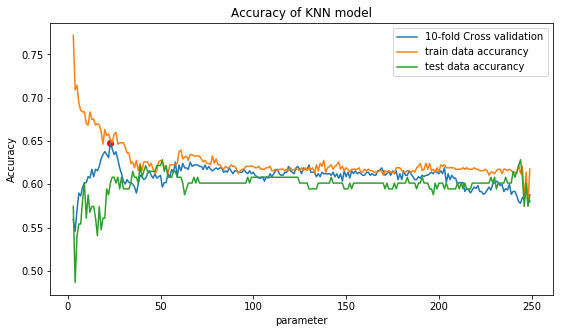

In [28]:
tune_param('KNN',np.arange(3,250,1),1,0,0,0,10)

best param=  9.9
traning score=  0.7789115646258503
our test data score= 0.7364864864864865
10-fold Cross Validation Accuracy: 0.76 (+/- 0.12)
7-fold Cross Validation Accuracy: 0.74 (+/- 0.06)
5-fold Cross Validation Accuracy: 0.74 (+/- 0.08)


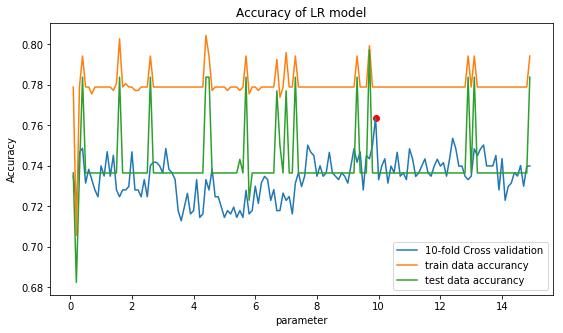

In [40]:
tune_param("LR",np.arange(0.1,15,0.1),1,0,0,0,10)

In [29]:
model_performance(model_init("LDA",0,0,0))

traning score=  0.8163265306122449
our test data score= 0.7905405405405406
10-fold Cross Validation Accuracy: 0.81 (+/- 0.09)
7-fold Cross Validation Accuracy: 0.81 (+/- 0.05)
5-fold Cross Validation Accuracy: 0.81 (+/- 0.05)


In [30]:
model_performance(model_init("QDA",0,0,0))

traning score=  0.7840136054421769
our test data score= 0.75
10-fold Cross Validation Accuracy: 0.77 (+/- 0.10)
7-fold Cross Validation Accuracy: 0.77 (+/- 0.09)
5-fold Cross Validation Accuracy: 0.77 (+/- 0.07)


best param=  20
traning score=  1.0
our test data score= 0.8513513513513513
10-fold Cross Validation Accuracy: 0.84 (+/- 0.08)
7-fold Cross Validation Accuracy: 0.83 (+/- 0.06)
5-fold Cross Validation Accuracy: 0.82 (+/- 0.02)


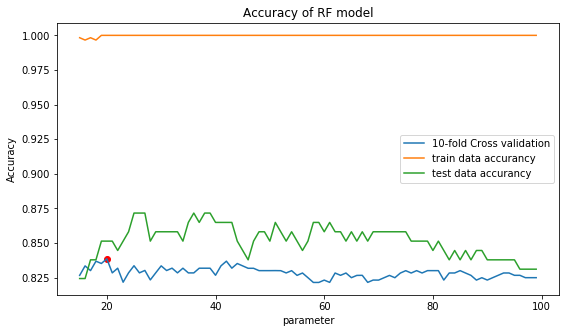

In [31]:
tune_param("RF",np.arange(15,100,1),1,0,0,0,10)

In [ ]:
#it is very clear in RF case, that choosing param according to
#cross validation is wrong, since it takes its maximum value
#when we get overfiting, note that the traning score is exactly one
#and in this case test error is very big comapring to other cases
#so it is better to take value where we have high traning and high
#test accurancy at the same time, visually this coresponds to around 25
#maybe we can change our cretaria to Max(corrs_val**2+test_accur**2)

In [32]:
## All LIKE is to output all "1" to check the accuracy

print("All Like")
print(' Test data accuracy：',accuracy_score \
      (org_data['label'],np.full([len(org_data['label']),1], 1)))

All Like
 Test data accuracy： 0.6026666666666667


In [33]:
#to decide tree size in the base clasifier for ADABoost model
#we need, as per lecture notes, to make sure that end nodes
#of base model equals to predictor cout +1=14


for i in range(10):
    tree=DecisionTreeClassifier(max_depth=i+1)
    tree.fit(x_train,y_train)
    print("depth= " , i+1 , "node count= ", tree.tree_.node_count)
    

depth=  1 node count=  3
depth=  2 node count=  7
depth=  3 node count=  15
depth=  4 node count=  31
depth=  5 node count=  53
depth=  6 node count=  73
depth=  7 node count=  87
depth=  8 node count=  103
depth=  9 node count=  119
depth=  10 node count=  139


best param=  1800
traning score=  1.0
our test data score= 0.8378378378378378
10-fold Cross Validation Accuracy: 0.81 (+/- 0.13)
7-fold Cross Validation Accuracy: 0.83 (+/- 0.09)
5-fold Cross Validation Accuracy: 0.84 (+/- 0.08)


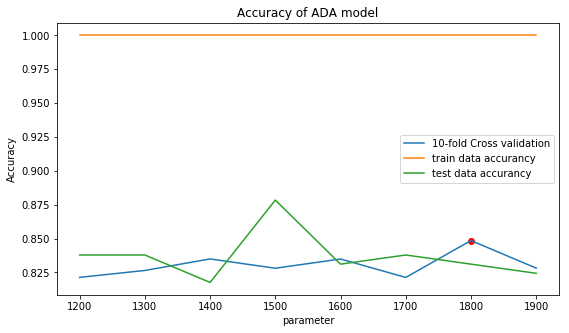

In [36]:
#from which we chose depth=3 as most suitable one
#it is enough for now to check 5-fold to increase speed
tune_param("ADA",np.arange(1200,2000,100),1,0,3,0,5) 

best param=  1810
traning score=  1.0
our test data score= 0.8445945945945946
10-fold Cross Validation Accuracy: 0.82 (+/- 0.11)
7-fold Cross Validation Accuracy: 0.83 (+/- 0.08)
5-fold Cross Validation Accuracy: 0.83 (+/- 0.10)


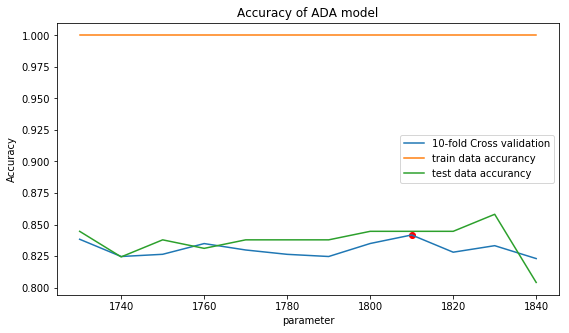

In [38]:
#lets squeze our serach more to find more accurate value
tune_param("ADA",np.arange(1730,1850,10),1,0,3,0,5)

In [34]:
#As per documentation, MLPClassifier is not scale invariant method
#thus we need to standartise all of our inputs
#for that we use StandardScaler method that will transform our data so that
#it has mean 0 and std=1
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(x_train)  

#transform train and test data to make everything consistent
x_train_std = scaler.transform(x_train)  
x_test_std = scaler.transform(x_test)

best param=  3
traning score=  0.8639455782312925
our test data score= 0.831081081081081
10-fold Cross Validation Accuracy: 0.82 (+/- 0.14)
7-fold Cross Validation Accuracy: 0.82 (+/- 0.06)
5-fold Cross Validation Accuracy: 0.81 (+/- 0.13)


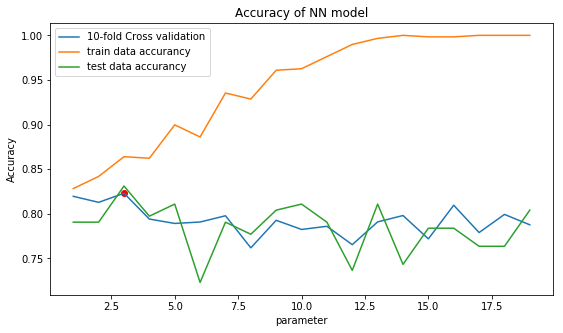

In [35]:
tune_param('NN',np.arange(1,20,1),3,'lbfgs','relu',0,7,xtrain=x_train_std,xtest=x_test_std)

In [ ]:
model=RandomForestClassifier(n_estimators=25, random_state=7)
model.fit(x_train,y_train)
print (model.predict(test_data))